# Notebook Isotooppitutkimukset ja hoidot STUK avoin datan tarkasteluun
- Tämä notebook käsittelee säteilyturvakeskuksen julkaisemaan avointa dataa. Soluja ajamalla voit tarkastella erilaisia tulosteita.
- Analyysit on tehty [Pandas-kirjastolla](https://pandas.pydata.org/docs/index.html) ja tulosteet [Plotly-kirjastolla](https://plotly.com/)
- Koodit ja osa koostetusta datasta löytyy [github projektisivulta](https://github.com/sinkinen/Isotooppitutkimukset_ja_hoidot_Suomessa_STUK_avoin_data_projekti). Käy lataamassa datat ja siirrä ne juureen.

**Lisäksi käy lataamassa seuraavat aineistot:**
1. [STUK avoin data isotooppitutkimukset ja hoidot suomessa](https://www.stuk.fi/avoin-data/isotooppitutkimukset-ja-hoidot-suomessa)
2.  [Sairaanhoitopiirien paikkatiedot: 'healthDistrictsEPSG4326.geojson'](https://github.com/VuokkoH/koronavirus-avoindata)

Siirrä lataamasi aineisto  juureen

**Muuta** 

Tätä notebookkkia voi ajaa [csc notebooks ympäristössä](https://notebooks.rahtiapp.fi/welcome). Valitse Jupyter Machine Learning ympäristö ja siirrä kaikki data virtuaaliympäristön juureen.

*FYI:* Soluja läpikäytäessä komentorivikyselyissä  enterillä voit suoraan hyväksyä oletussyötteen. *Mikäli kuva ei tulosta ensimmäisellä solun ajolla, kokeile ajaa solu uudestaan.* Jostakin syystä ensimmäisen plottauksen kohdalla vaaditaan kaksi kertaa solun ajaminen jupyter notebookissa (bugi?).


23.5.2023 Satu Inkinen

### Tarvittavien kirjastojen asennus:
Kestää muutaman minuutin ajan

In [1]:
%%capture
%pip install openpyxl
%pip install plotly
%pip install chart_studio
%pip install geojson
%pip install geopandas
%pip install moviepy
%pip install -U kaleido

### Kirjastojen lataaminen

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import plotly.express as px
import plotly.graph_objects as go
import io 
import plotly.offline as py
py.init_notebook_mode(connected=True) #asetus, jotta plotlyn grafiikat näkyy notebookissa

import plotly.io as pio
pio.renderers.default = 'colab' #asetus, jotta plotlyn grafiikat näkyy notebookissa
from plotly.offline import init_notebook_mode, iplot

import warnings
warnings.filterwarnings("ignore")

### Datojen lataaminen

Taulukkomuotoista ja geojson dataa on kerätty useammasta lähteestä. Koodiin on kommentoitu mistä lähteestä mikäkin data on kerätty.


In [3]:
def modify_coordinatesystem(dfg):
    '''Funktio muokkaa geopandasin koordinaatistotyypin '''
    
    dfg = dfg.explode() 
    dfg = dfg.to_crs(pyproj.CRS.from_epsg(4326))
    dfg.reset_index()
    return dfg

#Taulukkotilastot tutkimuksista ja hoidoista:
fname = "./Isotooppitutkimukset ja -hoidot Suomessa vuosina 2012, 2015, 2018 ja 2021 (.xlsx).xlsx"   #STUK data: huom tämä pitää käydä lataamassa sivustolta!

#Geodata karttojen piirtoja varten:
fname_geodata_ERVA = 'Geodata.geojson' #ERVA-alueet
fname_geodata_koord = 'Lat_long_erva.xlsx' #Latitudi ja longitudi koordinaatit
fname_geodata_SHP = 'healthDistrictsEPSG4326.geojson' # Ladattu: https://github.com/VuokkoH/koronavirus-avoindata

#Väestötiedot:
fname_popu_ERVA = 'ERVA_väestö_vuosittain.xlsx' #Vuosittain ERVA-alueiden väestöt tilastokeskuksen sivuilta  
fname_popu_SHP = 'SHP_väestö_2021.xlsx' #Vuosittain SHP-aluiden asukaslkm: https://www.kuntaliitto.fi/sites/default/files/media/file/Kartta_Ervat_Sairaanhoitopiirit2021.pdf

#Tutkimuskoodien ryhmittelytaulukko:
fname_types = 'Jaottelu.xlsx'

#Nimikkeiden yhdistämistaulukko:
fname_link = 'Linkkeri_shp_tiedot_geojson.csv'


#Datan sisäänluku:
df = pd.read_excel(fname, sheet_name=1, skiprows = 3) #Pandas dataframe

dfg_ERVA = gpd.read_file(fname_geodata_ERVA)
dfg_ERVA = modify_coordinatesystem(dfg_ERVA)

dfg_lat_lon = pd.read_excel(fname_geodata_koord)

dfg_ERVA = dfg_ERVA.merge(dfg_lat_lon, how='outer', left_on='Maakunta', right_on = "Erva") #yhdistetään tiedot koordinaatit ja polygon
dfg_ERVA = dfg_ERVA.drop(['Erva'], axis=1)


df_p_ERVA = pd.read_excel(fname_popu_ERVA)
df_p_SHP = pd.read_excel(fname_popu_SHP)

df_groups = pd.read_excel(fname_types)


dfg_ERVA = dfg_ERVA.merge(df_p_ERVA, how='outer', left_on='Maakunta', right_on = 'Erva') #yhdistetään tiedot: geodata ja asukaslkm
dfg_ERVA = dfg_ERVA.drop(['Maakuntakeskus', 'Asukasluku (2012)', 'Pinta-ala (km2)', 'Maakunta'], axis=1)  #poistetaan turha data
 
try:    
    dfg_SHP = gpd.read_file(fname_geodata_SHP)
    dfg_SHP = modify_coordinatesystem(dfg_SHP)
    dfg_SHP = dfg_SHP.drop(['population_31_12_2018'], axis=1) #poistetaan turha data
    dfg_SHP = dfg_SHP.dissolve(by='healthCareDistrict')
except:
    raise RuntimeError("Datan lataus ei onnistu. Tarkista oletko ladannut geojson datan: healthDistrictsEPSG4326.geojson osoitteesta: https://github.com/VuokkoH/koronavirus-avoindata ja asettanut sen juureen.")


    
linker_df = pd.read_csv(fname_link,  index_col = False) #taulukoitu nimet jotta yhdistäminen onnistuu oikein muuttujien kesken

dfg_SHP = dfg_SHP.merge(linker_df, how='outer', left_on='healthCareDistrict', right_on = '0')
dfg_SHP = dfg_SHP.rename(columns={"1": "Sairaanhoitopiiri"})
dfg_SHP = dfg_SHP.drop(["0"], axis=1)
dfg_SHP = dfg_SHP.merge(df_p_SHP, how='outer', left_on='Sairaanhoitopiiri', right_on = "Sairaanhoitopiiri")

print("Data luettu.")
print("")
print("df muuttujassa, joka sisältää STUK avoimen aineiston pitäisi olla 3553 riviä, ja luettu sisään: " + str(len(df)) +" riviä")
print("dfg_ERVA muuttujassa, joka sisältää ERVA alueiden geodataa ja asukaslukumäärät vuositasolla pitäisi olla 20 riviä, ja luettu sisään: " + str(len(dfg_ERVA)) +" riviä")
print("dfg_SHP muuttujassa, joka sisältää SHP alueiden geodataa ja asukaslukumäärät vuositasolla pitäisi olla 21 riviä, ja luettu sisään: " + str(len(dfg_SHP)) +" riviä")


Data luettu.

df muuttujassa, joka sisältää STUK avoimen aineiston pitäisi olla 3553 riviä, ja luettu sisään: 3550 riviä
dfg_ERVA muuttujassa, joka sisältää ERVA alueiden geodataa ja asukaslukumäärät vuositasolla pitäisi olla 20 riviä, ja luettu sisään: 20 riviä
dfg_SHP muuttujassa, joka sisältää SHP alueiden geodataa ja asukaslukumäärät vuositasolla pitäisi olla 21 riviä, ja luettu sisään: 21 riviä


### Pylväsdiagrammikuvaaja tutkimuskoodi ja vuoden mukaan
**Käyttäjä valitse komentoriviltä:**
1. tarkasteltva vuosi
2. tutkimuskoodi
3. ryhmiteltävä muuttuja
4. tarkasteltava muuttuja
5. tallennusnimi

Huom. enterillä voit suoraan hyväksyä oletussyötteen. Mikäli kuva ei tule ensimmäisellä solun ajolla, kokeile uudestaan. Jostakin syystä ensimmäisen plottauksen kohdalla vaaditaan kaksi kertaa solun ajaminen jupyter notebookissa (bugi?).

Tutkimuskoodeja kokeiltavaksi:
- KA1FN: Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)
- PJ5AQ: Vartijaimusolmukkeen SPET ja matala-annos-TT
- FM1TQ: sydänlihasperfuusio lepo ja rasitus
- JN6DR: Koko kehon aineenvaihdunnan PET-tietokonetomografiatutkimus


In [4]:
def plot_bar(df, ryhma, muuttuja_n, title_ = "testi",savename='img.png'):
    ''' Laskee painotetunkeskiarvo tai summatuloksen (lkm) muuttuja_n:stä '''

    df[ryhma] = df[ryhma].str.lower()
    df_filt = df[(df['Koodi']==koodi) & (df['Vuosi']==int(vuosi))] #suodatus koodin ja vuoden mukaan

    def group_wa(series): #painotettu keskiarvo lukumäärän suhteen, joka ei huomioi NAN arvoja
        dropped = series.dropna()
        if len(dropped) > 0:
            mean_val =  np.average(dropped, weights=df_osa.loc[dropped.index, 'Lukumäärä'])
        else:
            mean_val = np.nan
        return mean_val 

    if muuttuja_n=="aktiivisuus":
        muuttuja_n = "Keskimäärin käytetty aktiivisuus (MBq) 1"
        yaxis_title = "Aktiivisuus (MBq)"
        
    elif  muuttuja_n=="lukumäärä":  #lukumäärälle määritetään summa
        muuttuja_n ="Lukumäärä"
        yaxis_title = "Lukumäärä"

    elif  muuttuja_n=="DLP":
        muuttuja_n= "DLPw (mGY∙cm) 1"
        yaxis_title = "DLP (mGy∙cm)"

    elif muuttuja_n=="CTDIvol":
        muuttuja_n = "CTDIvol (mGy) 1"
        yaxis_title = "CTDIvol (mGy)"

    if muuttuja_n != "Lukumäärä":
        df_osa = df_filt[['Koodi', 'Vuosi', 'Tutkimusnimike', 'Lukumäärä', ryhma, muuttuja_n]] 
    else:
        df_osa = df_filt[['Koodi', 'Vuosi', 'Tutkimusnimike', ryhma, muuttuja_n]] 
    
    if muuttuja_n != "Lukumäärä":
        agg_func = {muuttuja_n: group_wa}
        result = df_osa.groupby(ryhma).agg(agg_func)
    else:
        result = df_osa.groupby(ryhma)["Lukumäärä"].sum().to_frame()
        
        
    result_lkm = df_osa.groupby(ryhma).sum()
            
    x = result.index
    y = result[muuttuja_n] 
        
    fig = go.Figure()
    fig.add_trace(go.Bar(
            x = x,
            y =  y,
            text = result_lkm['Lukumäärä']
        ))
    
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=title_, width =100*len(x), yaxis_title=yaxis_title)
    fig.update_yaxes(range=[0,y.max()*1.1])
    fig.write_image(savename, scale=3)
    fig.show()
    
    
# Kysytään käyttäjäinputit:
vuosi = input("Valitse tarkasteltava vuosi {2012,2015,2018,2021}? (default: 2021) ") or "2021"
koodi = input("Valitse  tutkimuskoodi? (default: NK6AN) ") or "NK6AN"
ryhma = input("Valitse ryhmiteltävä muuttuja (Sairaanhoitopiiri, Kunta, Turvallisuusluvan haltija, Erityisvastuualue )? (default: Erityisvastuualue) ") or "Erityisvastuualue"
muuttuja_n = input("Valitse tarkasteltava muuttuja (aktiivisuus, lukumäärä, DLP, CTDIvol ) ? (default: aktiivisuus) ") or "aktiivisuus"
save_name = input("Kuvan tallennusnimi? (default: img_bar.png) ") or "img_bar.png"
print('================================')
print('Valitsit:')
print(vuosi)
print(koodi)
print(ryhma)
print(muuttuja_n)
print('================================')

#Muodostetaan kuvaaja:
nimi = df[df['Koodi']==koodi].Tutkimusnimike.iloc[0]

plot_bar(df,  ryhma, muuttuja_n,nimi+' '+koodi, save_name)

Valitse tarkasteltava vuosi {2012,2015,2018,2021}? (default: 2021)  
Valitse  tutkimuskoodi? (default: NK6AN)  
Valitse ryhmiteltävä muuttuja (Sairaanhoitopiiri, Kunta, Turvallisuusluvan haltija, Erityisvastuualue )? (default: Erityisvastuualue)  
Valitse tarkasteltava muuttuja (aktiivisuus, lukumäärä, DLP, CTDIvol ) ? (default: aktiivisuus)  
Kuvan tallennusnimi? (default: img_bar.png)  


Valitsit:
2021
NK6AN
Erityisvastuualue
aktiivisuus


### Viivadiagrammi vuosien mukaan
**Käyttäjä valitse komentoriviltä:**
1. tutkimuskoodi
2. ryhmiteltävä muuttuja
3. tarkasteltava muuttuja
4. tallennusnimi

Huom. enterillä voit suoraan hyväksyä oletussyötteen komentiriville

Tutkimuskoodeja kokeiltavaksi:
- KA1FN: Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)
- PJ5AQ: Vartijaimusolmukkeen SPET ja matala-annos-TT
- FM1TQ: sydänlihasperfuusio lepo ja rasitus
- JN6DR: Koko kehon aineenvaihdunnan PET-tietokonetomografiatutkimus

In [5]:
def plot_trend(df_, ryhma, muuttuja_n, title_ = "testi",savename='img.png'):
    ''' Laskee painotetunkeskiarvo tai summatuloksen (lkm) muuttuja_n:stä '''
    
    df_[ryhma] = df_[ryhma].str.lower()
    df_[ryhma] = df_[ryhma].str.strip()

    
    df_filt = df_[(df_['Koodi']==koodi)] #suodatus koodin mukaan

    def group_wa(series): #painotettu keskiarvo lukumäärän suhteen, joka ei huomioi NAN arvoja
        dropped = series.dropna()
        if len(dropped) > 0:
            mean_val =  np.average(dropped, weights=df_osa.loc[dropped.index, 'Lukumäärä'])
        else:
            mean_val = np.nan
        return mean_val 

    if muuttuja_n =="aktiivisuus":
        muuttuja_n = "Keskimäärin käytetty aktiivisuus (MBq) 1"
        yaxis_title = "Aktiivisuus (MBq)"
        
    elif  muuttuja_n=="lukumäärä":  #lukumäärälle määritetään summa
        muuttuja_n ="Lukumäärä"
        yaxis_title = "Lukumäärä"
        
        def group_wa(series): #summa lukumäärän suhteen, joka ei huomioi NAN arvoja
            dropped = series.dropna()
            if len(dropped) > 0:
                mean_val =  np.sum(dropped)
            else:
                mean_val = np.nan
            return mean_val 
   
    elif  muuttuja_n=="DLP":
        muuttuja_n = "DLPw (mGY∙cm) 1"
        yaxis_title = "DLP (mGy∙cm)"

    elif muuttuja_n=="CTDIvol":
        muuttuja_n = "CTDIvol (mGy) 1"
        yaxis_title = "CTDIvol (mGy)"

    
    if muuttuja_n != "Lukumäärä":
        df_osa = df_filt[['Koodi', 'Vuosi', 'Tutkimusnimike', 'Lukumäärä', ryhma, muuttuja_n]] 
    else:
        df_osa = df_filt[['Koodi', 'Vuosi', 'Tutkimusnimike', ryhma, muuttuja_n]] 
       
    agg_func = {muuttuja_n: group_wa}
       
    result = df_osa.groupby([ryhma, "Vuosi"]).agg(agg_func)
    result_lkm = df_osa.groupby([ryhma, "Vuosi"]).sum()
    
    
    ryhmat = df_osa[ryhma].unique()
    fig = go.Figure()
    for ryhma_osa in ryhmat:
        try:
            specific_group = result.loc[(ryhma_osa)]
            x = specific_group.index
            y = specific_group[muuttuja_n] 
        except:
            print('')
            
   
        
        fig.add_trace(go.Scatter(
                x = x,
                y =  y,
                name = ryhma_osa,
                #text = result_lkm['Lukumäärä']
            ))

    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=title_, width =len(x)*250, yaxis_title=yaxis_title)
    fig.update_yaxes(range=[0,result[muuttuja_n].max()*1.1])
    fig.write_image(savename, scale=3)
    fig.show()
    
    
# Kysytään käyttäjäinputit:
koodi = input("Valitse  tutkimuskoodi? (default: NK6AN) ") or "NK6AN"
ryhma = input("Valitse ryhmiteltävä muuttuja (Sairaanhoitopiiri, Kunta, Turvallisuusluvan haltija, Erityisvastuualue )? (default: Kunta) ") or "Kunta"
muuttuja_n = input("Valitse tarkasteltava muuttuja (aktiivisuus, lukumäärä, DLP, CTDIvol) ? (default: lukumäärä) ") or "lukumäärä"
save_name = input("Kuvan tallennusnimi? (default: img_trend.png) ") or "img_trend.png"
print('================================')
print('Valitsit:')
print(koodi)
print(ryhma)
print(muuttuja_n)
print('================================')

nimi = df[df['Koodi']==koodi].Tutkimusnimike.iloc[0]
#Muodostetaan kuvaaja:
plot_trend(df,  ryhma, muuttuja_n, koodi+' '+nimi, save_name)

Valitse  tutkimuskoodi? (default: NK6AN)  
Valitse ryhmiteltävä muuttuja (Sairaanhoitopiiri, Kunta, Turvallisuusluvan haltija, Erityisvastuualue )? (default: Kunta)  
Valitse tarkasteltava muuttuja (aktiivisuus, lukumäärä, DLP, CTDIvol) ? (default: lukumäärä)  
Kuvan tallennusnimi? (default: img_trend.png)  


Valitsit:
NK6AN
Kunta
lukumäärä


### Tutkimusmäärät vuositrendi lapset ja aikuiset

In [6]:
def Tutkimus_maarat_glob(data,  ikä = 'Aikuinen', vuosi=2021, kuv_tut_tyyppi='Tutkimus'):
    
    df_ = data[data['Vuosi']==vuosi]
    df_ = df_[df_['Ikä']==ikä]
    df_ = df_[df_['Kuvaus tutkimuksen tyypistä']==kuv_tut_tyyppi]  
    df_2 = df_[["Ikä", "Lukumäärä"]]
    
    sum_val = df_2['Lukumäärä'].sum()
    
    return  sum_val


nimi = df[df['Koodi']==koodi].Tutkimusnimike.iloc[0]


vuodet = df["Vuosi"].unique() 
df_sum = []
for vuosi in vuodet:
    sum_val_l = Tutkimus_maarat_glob(df,  ikä = 'Lapsi', vuosi=vuosi, kuv_tut_tyyppi='Tutkimus')
    sum_val_a = Tutkimus_maarat_glob(df,  ikä = 'Aikuinen', vuosi=vuosi, kuv_tut_tyyppi='Tutkimus')
    df_sum.append({'Vuosi': str(vuosi), 'Sum_lapsi': sum_val_l, 'Sum_aikuinen': sum_val_a})
df_sum  = pd.DataFrame(df_sum)

#Muodostetaan kuvaajat:
fig = px.bar(df_sum, x="Vuosi", y="Sum_lapsi", text_auto=True, labels={'Sum_lapsi':'Tutkimusten lukumäärä'}, width =500, title="Lapset")
fig.update_xaxes(tickmode='linear', ticklabelmode="period")
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='black', ticklen=5, col=1, range=[0, 5000])
fig.write_image("lapset_vuosi_lkm.png", scale=5)
fig.show()

fig = px.bar(df_sum, x="Vuosi", y="Sum_aikuinen", text_auto=True, labels={'Sum_aikuinen':'Tutkimusten lukumäärä'}, width =500, title="Aikuiset")
fig.update_xaxes(tickmode='linear', ticklabelmode="period")
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='black', ticklen=5, col=1, range=[0, 50000])
fig.write_image("aikuiset_vuosi_lkm.png", scale=5)
fig.show()


### Eniten tehdyt tutkimukset SHP alueittain:
- lasten osalta ei välttämättä löydy joka alueelta kirjattuna tutkimuksia 


Valitse  ikä: {Aikuinen, Lapsi}? (default: Lapsi)  
Valitse  tutkimusten lukumäärä? (default: 5)  


Valitsit:
Lapsi
5
Ei 5 kpl tutkimuksia: keski-pohjanmaan shp
Ei 5 kpl tutkimuksia: kainuun shp
Ei 5 kpl tutkimuksia: etelä-savon shp
Ei 5 kpl tutkimuksia: itä-savon shp
Ei 5 kpl tutkimuksia: keski-pohjanmaan shp
Ei 5 kpl tutkimuksia: etelä-pohjanmaan shp
Ei 5 kpl tutkimuksia: etelä-savon shp
Ei 5 kpl tutkimuksia: itä-savon shp
Ei 5 kpl tutkimuksia: keski-pohjanmaan shp
Ei 5 kpl tutkimuksia: etelä-pohjanmaan shp
Ei 5 kpl tutkimuksia: kainuun shp
Ei 5 kpl tutkimuksia: lapin shp
Ei 5 kpl tutkimuksia: etelä-savon shp
Ei 5 kpl tutkimuksia: itä-savon shp
Ei 5 kpl tutkimuksia: länsi-pohjan shp
Ei 5 kpl tutkimuksia: kymenlaakson shp
Kuvaaja-asetukset:


Valitse  vuosi {2012, 2015, 2018, 2021}? (default: 2021)  


,Vuosi,Sairaanhoitopiiri,Tutkimusnimet
3,2021,varsinais-suomen shp,"[Luuston dynaaminen/useampivaiheinen gammakuvaus, Kromaffiinikudoksen SPET ja matala-annos-TT, Kehon aineenvaihdunnan laaja PET-magneettitutkimus, Glomerulusten suodatusnopeuden (GFR) mittaus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]"
7,2021,varsinais-suomen shp,"[Luuston dynaaminen/useampivaiheinen gammakuvaus, Kromaffiinikudoksen SPET ja matala-annos-TT, Kehon aineenvaihdunnan laaja PET-magneettitutkimus, Glomerulusten suodatusnopeuden (GFR) mittaus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]"
11,2021,etelä-karjalan shp,"[Sydämen oikovirtauksen gammakuvaus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]"
13,2021,etelä-pohjanmaan shp,"[Keuhkojen alueellisen toiminnan gammakuvaus, Kilpirauhasmetastaasien gammakuvaus ablaation yhteydessä, Keuhkoperfuusion ja ventilaation SPET]"
18,2021,helsingin ja uudenmaan shp,"[Sappiteiden gammakuvaus, Munuaisparenkyymin gammakuvaus, Koko kehon aineenvaihdunnan PET-tietokonetomografiatutkimus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena), Glomerulusten suodatusnopeuden (GFR) mittaus]"
25,2021,kanta-hämeen shp,"[Keuhkoperfuusion SPET, Keuhkoventilaation SPET, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]"
26,2021,keski-pohjanmaan shp,[Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]
30,2021,keski-suomen shp,"[Lisäkilpirauhasen laaja gammakuvaus, 2 isotooppia, SPET ja matala-annos-TT, Luuston gammakuvaus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena)]"
43,2021,pirkanmaan shp,"[Imuteiden gammakuvaus, Kromaffiinikudoksen SPET ja matala-annos-TT, Koko kehon aineenvaihdunnan laaja PET-tietokonetomografiatutkimus, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena), Glomerulusten suodatusnopeuden (GFR) mittaus]"
47,2021,pohjois-karjalan shp,"[Luuston gammakuvaus, Tulehduspesäkkeen laaja SPET ja matala-annos-TT, Munuaistoiminnan gammakuvaus (myös diureettitehosteisena), Virtsan refluksin gammakuvaus, radiolääke virtsakatetrin kautta, Glomerulusten suodatusnopeuden (GFR) mittaus]"


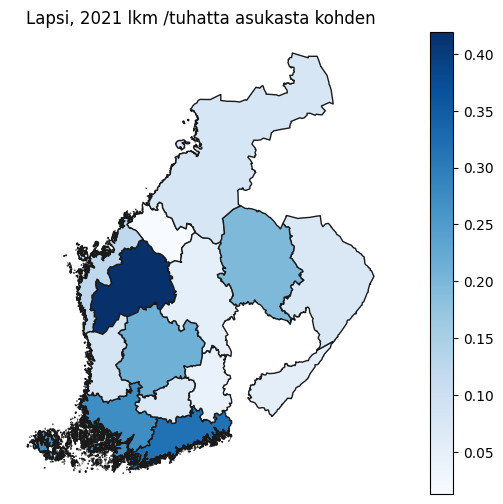

In [7]:
def top_nkpl_tutkimukset(data, alue ='varsinais-suomen shp', ikä = 'Aikuinen', vuosi=2021, n=10, visualize = True, count=0,  tut_tyyppi='Tutkimus'):

    #filtteröinti:
    df_ = data[data['Vuosi']==vuosi]
    df_ = df_[df_['Ikä']==ikä]
    df_ = df_[df_['Kuvaus tutkimuksen tyypistä']==tut_tyyppi] 
    df_ = df_[df_['Sairaanhoitopiiri']==alue]
    df_ = df_[["Tutkimusnimike", "Lukumäärä"]]
    
    df_sum = pd.pivot_table(df_, index=['Tutkimusnimike'],values=['Lukumäärä'],aggfunc='sum')
    df_crop = df_sum.sort_values(by=['Lukumäärä'], ascending=False)
    dft = df_crop.head(n) 
    
    if visualize:
        axel = dft.plot(kind='bar', rot=90, title=alue, ax=axes[count])
        axel.set_ylim(0, 3000)
    dft = dft.sort_values('Lukumäärä', ascending=True)

    return  dft


def tutkimus_maarat(data, alue ='varsinais-suomen shp', ikä = 'Aikuinen', vuosi=2021, tut_tyyppi='Tutkimus'):
    
    #filtteröinti:
    df_ = data[data['Vuosi']==vuosi]
    df_ = df_[df_['Ikä']==ikä]
    df_ = df_[df_['Kuvaus tutkimuksen tyypistä']==tut_tyyppi]     
    df_ = df_[df_['Sairaanhoitopiiri']==alue]
    df_ = df_[["Tutkimusnimike", "Lukumäärä"]]

    sum_val = df_['Lukumäärä'].sum()
    
    return  sum_val


def tutkimusyypit(data, alue ='HYKS', ikä = 'Aikuinen', vuosi=2021,  kuv_tut_tyyppi='Tutkimus'):
   
    #filtteröinti:
    df_ = data[data['Vuosi']==vuosi]
    df_ = df_[df_['Ikä']==ikä]
    df_ = df_[df_['Kuvaus tutkimuksen tyypistä']==kuv_tut_tyyppi] 
    df_ = df_[df_['Sairaanhoitopiiri']==alue]
    df_ = df_[["Tutkimuksen tyyppi", "Lukumäärä"]]
    
    df_sum = pd.pivot_table(df_, index=['Tutkimuksen tyyppi'],values=['Lukumäärä'],aggfunc='sum')
    
    df_crop = df_sum.sort_values(by=['Lukumäärä'], ascending=False)
    dft = df_crop 
    dft = dft.sort_values('Lukumäärä', ascending=True)

    return  dft


# Kysytään käyttäjäinputit:
ikä = input("Valitse  ikä: {Aikuinen, Lapsi}? (default: Lapsi) ") or "Lapsi"
n_lkm = input("Valitse  tutkimusten lukumäärä? (default: 5) ") or "5"
print('================================')
print('Valitsit:')
print(ikä)
print(n_lkm)
print('================================')


df["Sairaanhoitopiiri"] = df["Sairaanhoitopiiri"].str.lower()
df["Sairaanhoitopiiri"] = df["Sairaanhoitopiiri"].str.strip()

visualize = True
shpt =  df.Sairaanhoitopiiri.unique()
vuodet = df.Vuosi.unique()


dct_stat = []
for vuosi in vuodet:
    for count,  shp in enumerate(shpt):
        try:
            sum_val = tutkimus_maarat(df, shp, ikä, vuosi)
            dft = top_nkpl_tutkimukset(df, shp, ikä, vuosi, int(n_lkm), False)
            top_lista = dft.index.to_list()         
            tut_tyyppi = tutkimusyypit(df, shp, ikä, vuosi)
            dct_stat.append({ 'Vuosi': vuosi, 'Sairaanhoitopiiri': shp, 'TutkimusSumma': sum_val, 'Tutkimusnimet': top_lista,'Määrät': dft['Lukumäärä'].to_list(), 'Tutkimustyyppi': tut_tyyppi.index.to_list() ,'TutkimustyyppiMäärät': tut_tyyppi['Lukumäärä'].to_list()   })
        except:
            print("Ei "+n_lkm+ " kpl tutkimuksia: "+ shp)
            
df_stat = pd.DataFrame(dct_stat)

dfg_top_tutkimukset = dfg_SHP.copy(False)
dfg_top_tutkimukset["Sairaanhoitopiiri"] = dfg_top_tutkimukset["Sairaanhoitopiiri"].str.lower()
dfg_top_tutkimukset["Sairaanhoitopiiri"] = dfg_top_tutkimukset["Sairaanhoitopiiri"].str.strip()

dfg_top_tutkimukset = dfg_top_tutkimukset.merge(df_stat, how='left', left_on=['Sairaanhoitopiiri'], right_on = ['Sairaanhoitopiiri'])

dfg_top_tutkimukset['Lkm_asukas'] = dfg_top_tutkimukset['TutkimusSumma']/ (dfg_top_tutkimukset['asukaslkm']/1000)
dfg_top_tutkimukset['Lkm_asukas'] = dfg_top_tutkimukset['Lkm_asukas'].round(decimals=4)


print('================================')
print("Kuvaaja-asetukset:")
vuosi = input("Valitse  vuosi {2012, 2015, 2018, 2021}? (default: 2021) ") or "2021"

from IPython.display import display, HTML

dfg_top_tutkimukset_crop = dfg_top_tutkimukset[dfg_top_tutkimukset["Vuosi"]==int(vuosi)]
dfg_top_tutkimukset_crop = dfg_top_tutkimukset_crop[["Vuosi", "Sairaanhoitopiiri", "Tutkimusnimet"]]
display(HTML(dfg_top_tutkimukset_crop.to_html()))



dfg_m_osa = dfg_top_tutkimukset[dfg_top_tutkimukset["Vuosi"]==int(vuosi)]
fig, ax = plt.subplots(1, figsize=(10,6))
dfg_m_osa.plot('Lkm_asukas', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.1', legend = True)
plt.title(ikä+', '+vuosi+ ' lkm /tuhatta asukasta kohden')
ax.axis('off')
plt.savefig(ikä+vuosi+'_tutkimuslukumäärät.png')

### Keskiarvo aktiivisuudet ja TT-annokset (DLP, CTDIvol) SHP alueittain vuositasolla

- Koodissa käytetään taulukkoa Jaottelu.xlsx hyödyksi, jossa on ryhmitelty manuaalisesti tutkimustyypit ja sitä vastaavat koodit esim. luusto: {NK6BN, NK6AN, NK7SN, NK6BQ, NK6SN, NK6AQ}.
- Taulukkoa voi halutessaaan itse muokata jos haluaa ryhmitellä dataa eritavalla
- Käyttäjän valinnat: vuosiluku

Huom. Ainoastaan aikuisten tutkimuksista löytyy annostiedot

In [8]:
def plot_bar_shp(df, savename='img.png', study_type="study_type", akt_keskiarvo=np.nan, stuk_vt=np.nan):
    ''' Plottaa pylväsdiagrammin keskiarvoaktiivisuuksista ja halutessaan voi antaa aktiivisuuskeskiarvon koko ryhmien yli tai stukin vertailutason '''
    
    colors = ['skyblue','cornflowerblue','dodgerblue','blue','darkblue'] #alustetaan värit

    fig = go.Figure() #alustetaan kuvaaja
    
    if ~np.isnan(akt_keskiarvo): #Jos eri kuin NaN niin piirretään viiva painotetusta keskiarvoannoksesta
        fig.add_trace(go.Scatter(x = df['Sairaanhoitopiiri'], y = [akt_keskiarvo,akt_keskiarvo,akt_keskiarvo,akt_keskiarvo, akt_keskiarvo],
                            mode='lines',opacity=0.5,
                            name='Keskiarvo',  line=dict(color='goldenrod', width=2)))

    if ~np.isnan(stuk_vt): #Jos eri kuin NaN niin piirretään viiva stukin vertailutasosta
        fig.add_trace(go.Scatter(x=df['Sairaanhoitopiiri'], y=[stuk_vt,stuk_vt,stuk_vt,stuk_vt, stuk_vt],
                            mode ='lines',opacity=0.5,
                            name ='STUK ver.taso',  line=dict(color='red', width=2)))

    #Plotataan tulokset erva-alueittain värikoodattuna:
    ervat = df["erva"].unique()
    for erva, color_ in zip(ervat, colors):
        df_ = df[df['erva']==erva]
        fig.add_trace(go.Bar(
            x = df_['Sairaanhoitopiiri'],
            y =  df_['Keskiarvo aktiivisuus'],
            name = erva,  
            marker_color=color_,
            text = df_['Lukumäärä']
        ))
    
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=study_type, width = 700, yaxis_title="Aktiivisuus (MBq)")
    fig.update_yaxes(range=[0,df['Keskiarvo aktiivisuus'].max()*1.1])    
    fig.write_image(savename, scale=3) #kuvan tallennus, scale parametri säätää kuvan resoluutiota
    fig.show()


def plot_bar_shp_dose(df, dose_type = 'CTDI',study_type="study_type", savename='img.png', dose_keskiarvo = np.nan):
    ''' Plottaa pylväsdiagrammin TT-annoksista ja halutessaan voi antaa aktiivisuuskeskiarvon koko ryhmien yli'''
    
    colors = ['skyblue','cornflowerblue','dodgerblue','blue','darkblue']

    #säädetään kuvaajan otsikko datatyypin mukaan:
    if dose_type=="DLP":
        yaxis_title = "DLP (mGy*cm)"
        lkm_index = "Lukumäärä_DLP"
    elif dose_type=="CTDI":
        yaxis_title = "CTDIvol (mGy)"
        lkm_index = "Lukumäärä_CTDI"
        
        
    fig = go.Figure()
    if ~np.isnan(dose_keskiarvo):
        fig.add_trace(go.Scatter(x=df['Sairaanhoitopiiri'], y=[dose_keskiarvo,dose_keskiarvo,dose_keskiarvo,dose_keskiarvo, dose_keskiarvo],
                            mode='lines',opacity=0.5,
                            name='Keskiarvo',  line=dict(color='goldenrod', width=2)))
    
    ervat = df["erva"].unique()
    for erva, color_ in zip(ervat, colors):
        df_ = df[df['erva']==erva]
        fig.add_trace(go.Bar(
            x = df_['Sairaanhoitopiiri'],
            y =  df_[dose_type],
            text = df_[lkm_index],
            name=erva,
            marker_color=color_,
        ))


    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=study_type, width =700, yaxis_title=yaxis_title)
    fig.update_yaxes(range=[0,df[dose_type].max()*1.1])
    fig.write_image(savename, scale=3)
    fig.show()
    

vuosi_ = input("Valitse  vuosi {2012, 2015, 2018, 2021}? (default: 2021) ") or "2021"
print(vuosi_+" valittu.")
Ikä = "Aikuinen"
tut_tyyppi = "Tutkimus"
df_types = df_groups[df_groups['Ikä']==Ikä]


#loopataan läpi eri tutkimustyypit Jaottelu.xlsx taulukosta ja tehdään kuvaajat
for study_type in df_types['Nimi'].unique(): 
    print(study_type)
    
    df_types_crop = df_types[df_types['Nimi'] == study_type]
    study_codes = df_types_crop['Tutkimusnimikkeet'].unique() #valitaan kyseisen tutkimusta vastaavat kuntaliittokoodit

    #Eritellään analyysi radionuklideittain
    r_nuc_lst = [] 
    r_nuc = df_types_crop["Radionuklidi"].unique()
    for nuc in r_nuc:
        if len(nuc.split(','))>1:
            for mja in nuc.split(','):
                 r_nuc_lst.append(mja)
        else:
            r_nuc_lst.append(nuc)
        
     
    for r_nuc in r_nuc_lst: #käydään eri radionuklidit läpi
        
        #filtteröinti:
        
            
        df_ = df[df['Vuosi']==int(vuosi_)]
      
        df_ = df_[df_['Ikä']==Ikä]
        df_ = df_[df_['Kuvaus tutkimuksen tyypistä']==tut_tyyppi]
        df_ = df_[df_['Radionuklidi 1']==r_nuc]
        
        df_crop = df_[df_['Koodi'].isin(study_codes)]

        
        #Painotettu keskiarvo, joka ignooraa NAN arvot:
        def group_wa(series):
            dropped = series.dropna()
            try:
                if len(dropped) > 0:

                    mean_val =  np.average(dropped, weights=df_crop.loc[dropped.index, 'Lukumäärä'])
                else:
                    mean_val = np.nan
            except:
                mean_val=np.nan
                print("virhe, taulukossa väärä syöte")

            return mean_val 
        
      
        #Painotettu keskiarvo-aktiivisuus
        agg_func = {'Keskimäärin käytetty aktiivisuus (MBq) 1': group_wa}
        akt_keskiarvo_ = df_crop.groupby('Sairaanhoitopiiri').agg(agg_func)
        akt_keskiarvo_kaikki = df_crop.agg(agg_func)

        #Tutkimusten lukumäärä
        lkm_keskiarvo_ = df_crop.groupby('Sairaanhoitopiiri')['Lukumäärä'].sum()
        
        df_dropped = df_crop.dropna(subset=['DLPw (mGY∙cm) 1'])
        lkm_DLP_ = df_dropped.groupby('Sairaanhoitopiiri')['Lukumäärä'].sum()

        df_dropped = df_crop.dropna(subset=['CTDIvol (mGy) 1'])
        lkm_CTDI_ = df_dropped.groupby('Sairaanhoitopiiri')['Lukumäärä'].sum()
            
        #DLP
        agg_func = {'DLPw (mGY∙cm) 1': group_wa}
        DLP_keskiarvo_ = df_crop.groupby('Sairaanhoitopiiri').agg(agg_func)
        DLP_keskiarvo_kaikki = df_crop.agg(agg_func)
        
        #CTDIvol
        agg_func = {'CTDIvol (mGy) 1': group_wa}
        CTDI_keskiarvo_ = df_crop.groupby('Sairaanhoitopiiri').agg(agg_func)
        CTDI_keskiarvo_kaikki = df_crop.agg(agg_func)

        #Tulosten keräys:
        i=0
        df_result = [] #Kerätään tulokset listaan
        for index in akt_keskiarvo_.index:
            
            sairaanhoitopiiri = index
            act_val =  akt_keskiarvo_.loc[index].to_numpy()
            lkm_val =  lkm_keskiarvo_.loc[index]
            try:
                lkm_DLP_val =  lkm_DLP_.loc[index] 
            except:
                lkm_DLP_val=np.nan
                
            try:
                lkm_CTDI_val =  lkm_CTDI_.loc[index] 
            except:
                lkm_CTDI_val=np.nan
                    
            DLP_val = DLP_keskiarvo_.loc[index].to_numpy()
            CTDI_val = CTDI_keskiarvo_.loc[index].to_numpy()
            
            df_crop_ = df_crop[df_["Sairaanhoitopiiri"]==sairaanhoitopiiri]

            erva = df_crop_['Erityisvastuualue'].to_numpy()[0]

            #Aseta tulokset dictionaryyn:
            dct_res = {'erva': erva, 'Sairaanhoitopiiri': sairaanhoitopiiri, 'Keskiarvo aktiivisuus':act_val[0], 'DLP':DLP_val[0], 'CTDI':CTDI_val[0],
                       'Lukumäärä': lkm_val, 'Radionuklidi':r_nuc, 'Vuosi':vuosi_,'Lukumäärä_DLP':lkm_DLP_val, 'Lukumäärä_CTDI':lkm_CTDI_val}
            df_result.append(dct_res)

            i+=1

        df_result = pd.DataFrame(df_result) #muutetaan dictionary dataFrameksi
        
        #Tallennusnimet:
        savename = 'Aikuinen_Akt_SHP_'+study_type+'_'+r_nuc+'.png'
        savename_ctdi = 'Aikuinen_CTDI_SHP'+study_type+'_'+r_nuc+'.png'
        savename_dlp = 'Aikuinen_DLP_SHP'+study_type+'_'+r_nuc+'.png'

        #Vertailutason määritys:
        vt =  df_types_crop[df_types_crop['Radionuklidi']==r_nuc]
        
        if len(vt)==0: #Ehtolause, jolla tarkistetaan löytyykö Jauottelu taulukosta vertailutasoa määriteltynä tutkimukselle:
            stuk_vt=np.nan    
        elif len(vt)==1:
            stuk_vt=vt['Vertailutaso'][0]
        else:
            stuk_vt=vt['Vertailutaso'].to_numpy()[0]
         

        if len(df_result) > 0: #Tarkistetaan että löytyikö koodilla dataa
            
            df_result2 = df_result[df_result['Radionuklidi']==r_nuc]   
            df_result2 = df_result2.sort_values(by=['erva'])
           
            #Tulostukset:
            plot_bar_shp(df_result2,savename=savename, study_type=study_type, akt_keskiarvo=akt_keskiarvo_kaikki.to_numpy()[0], stuk_vt=stuk_vt)   
            plot_bar_shp_dose(df_result2, dose_type = "CTDI", study_type=study_type, savename=savename_ctdi, dose_keskiarvo=CTDI_keskiarvo_kaikki.to_numpy()[0])
            plot_bar_shp_dose(df_result2, dose_type = "DLP", study_type=study_type, savename=savename_dlp, dose_keskiarvo=DLP_keskiarvo_kaikki.to_numpy()[0])

        #break
    #break

Valitse  vuosi {2012, 2015, 2018, 2021}? (default: 2021)  


2021 valittu.
Luusto


Aineenvaihdunta PET


Vartijaimusolmuke


Eturauhasen aineenvaihdunnan PET


###  Isotooppihoidot ERVA alueittain vuositasolla
- Tulostetaan kaikki tutkimukset


In [ ]:
def plot_bar_year_erva(df, savename='img.png', akt_keskiarvo=np.nan, stuk_vt=np.nan, tut_nimike=''):
    
    colors = ['skyblue','cornflowerblue','dodgerblue','blue']

    fig = go.Figure()
    if ~np.isnan(akt_keskiarvo):
        fig.add_trace(go.Scatter(x=df['ERVA'], y=[akt_keskiarvo,akt_keskiarvo,akt_keskiarvo,akt_keskiarvo, akt_keskiarvo],
                            mode='lines',opacity=0.5,
                            name='Keskiarvo 2021',  line=dict(color='goldenrod', width=2)))

    if ~np.isnan(stuk_vt):
        fig.add_trace(go.Scatter(x=df['ERVA'], y=[stuk_vt,stuk_vt,stuk_vt,stuk_vt, stuk_vt],
                            mode='lines',opacity=0.5,
                            name='STUK ver.taso',  line=dict(color='red', width=2)))

        
    for vuosi, color_ in zip(vuodet, colors):
        df_ = df[df['Vuosi']==vuosi]
        #import pdb; pdb.set_trace()
        fig.add_trace(go.Bar(
            x = df_['ERVA'],
            y =  df_['Keskiarvo aktiivisuus'],
            name=str(vuosi),  
            marker_color=color_,   text = df_['Lukumäärä']
        ))
    
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=tut_nimike, width =700, yaxis_title="Aktiivisuus (MBq)")
    fig.update_yaxes(range=[0,df_['Keskiarvo aktiivisuus'].max()*1.1])
    fig.write_image(savename, scale=3)
    fig.show()
  

df_osa = df[df["Kuvaus tutkimuksen tyypistä"]=="Isotooppihoito"]
tut_nimikkeet = df_osa["Tutkimusnimike"].unique()
Ikä = "Aikuinen"
tut_tyyppi = "Tutkimus"
vuodet = vuodet = df.Vuosi.unique()


for tut_nimike in tut_nimikkeet:
    print(tut_nimike)
    
    df_filt = df_osa[df_osa['Ikä']==Ikä]
    df_filt = df_filt[df_filt["Tutkimusnimike"]==tut_nimike]

    df_result = []
    for vuosi in vuodet:

        df_test = df_filt[df_filt['Vuosi']==vuosi]

        #painotettu keskiarvo huomioi NAN arvot:
        def group_wa(series):
            dropped = series.dropna()
            try:
                if len(dropped) > 0:

                    mean_val =  np.average(dropped, weights=df_test.loc[dropped.index, 'Lukumäärä'])
                else:
                    mean_val = np.nan
            except:
                import pdb; pdb.set_trace()

            return mean_val 

        agg_func = {'Keskimäärin käytetty aktiivisuus (MBq) 1': group_wa}
        akt_keskiarvo_erva = df_test.groupby('Erityisvastuualue').agg(agg_func)
        akt_keskiarvo = df_test.agg(agg_func) #df_test['Keskimäärin käytetty aktiivisuus (MBq) 1'].mean()

        lkm_keskiarvo_erva = df_test.groupby('Erityisvastuualue')['Lukumäärä'].sum()

        i=0
        for index in akt_keskiarvo_erva.index:
            act_val =  akt_keskiarvo_erva.loc[index].to_numpy()
            lkm_val =  lkm_keskiarvo_erva.loc[index]          
            erva = index

            dct_res = {'ERVA': erva, 'Keskiarvo aktiivisuus':act_val[0],'Lukumäärä': lkm_val,'Vuosi':vuosi}
            df_result.append(dct_res)
            i+=1


    df_result = pd.DataFrame(df_result) 
    savename = 'Aikuinen_Akt_vuosi_erva_'+tut_nimike+'.png'

    if len(df_result) > 0 :

        if len(akt_keskiarvo)==0:
             akt_keskiarvo = pd.DataFrame([np.nan])
        
        plot_bar_year_erva(df_result,savename=savename, akt_keskiarvo=akt_keskiarvo.to_numpy()[0], stuk_vt=np.nan, tut_nimike=tut_nimike)

Radiofosforihoito


Radiojodihoito, kilpirauhaskudos (Liikatoiminta)


Radiojodihoito, kilpirauhaskudos (Syöpä)


Radioyttriumhoito leimatulla vasta-aineella


Radioyttrium SIRT-hoito


Radiosamariumhoito


Nivelen isotooppihoito


Radiolääkehoito, Lutetium-177-DOTA


Radiolääkehoito, Radium-223


Radiojodihoito kromaffiinikudosligandilla


Lutetium-177-PSMA hoito


Torium-227 hoito
